# Imports

In [1]:
import numpy as np
import pandas as pd
import glob
import re
import sys

from bs4 import BeautifulSoup

from snorkel.labeling.lf import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter

# Load Data

In [2]:
def load_reviews(path, columns=["filename", 'review']):
    assert len(columns) == 2
    l = list()
    for filename in glob.glob(path):
        # print(filename)
        with open(filename, 'r') as f:
            review = f.read()
            l.append((filename, review))
    return pd.DataFrame(l, columns=columns)

unsup_df = load_reviews("./aclImdb/train/unsup/*.txt")

def load_labelled_data(path, neg='/neg/', 
                       pos='/pos/', shuffle=True):
    neg_df = load_reviews(path + neg + "*.txt")
    pos_df = load_reviews(path + pos + "*.txt")
    neg_df['sentiment'] = 0
    pos_df['sentiment'] = 1
    df = pd.concat([neg_df, pos_df], axis=0)
    if shuffle:
        df = df.sample(frac=1, random_state=42)
    return df

train_df = load_labelled_data("./aclImdb/train/")

test_df = load_labelled_data("./aclImdb/test/")

# Labeling Functions

In [3]:
# Constants
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

## Negative Sentiment Labeling Functions

In [4]:
# Sample some negative reviews and write some functions
train_df[train_df.sentiment == 0].review[:10].tolist()

["If you're in the mood for some dopey light entertainment, this will pass the time. If you expect one jot of plausibility, don't bother. To me, the dance scene looked like it was exaggerated for comic effect; it didn't look especially hot or skilled.",
 "Bottom of the barrel, unimaginative, and practically unwatchable remake of THE ROAD WARRIOR. This film follows the exact plot as the Filipino film STRYKER and is worse by far! Bad acting, dialog, effects, dubbing, pacing, action sequences... The list goes on and on. Italy made literally dozens of Road Warrior rip-offs in the early 80's, some good, some bad. This is the worst by far, no contest. Not only was the mood of the film completely bleak and miserable, the experience of sitting through this one is a bore and a half. There was 1 (one) good chase sequence towards the beginning of the movie, and a cool shot of a man holding a hand grenade exploding. But EVERYTHING else about this movie seriously reeks! For actual post-nuke fun, go

In [5]:
@labeling_function()
def atrocious(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "atrocious"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def crap(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "crap"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def garbage(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "garbage"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN


@labeling_function()
def terrible(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "terrible"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def piece_of(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = {"piece", "of", "junk"}
    st_rvw = set(x.review.lower().split())
    if st_rvw.issuperset(ex1):
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def woefully_miscast(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "woeful"
    ex2 = "miscast"
    if ex1 in x.review.lower() or ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def bad_acting(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "bad"
    ex2 = "acting"
    if ex1 in x.review.lower() and ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def cheesy_dull(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "cheesy"
    ex2 = "dull"
    if ex1 in x.review.lower() or ex2 in x.review.lower():
        return NEGATIVE
    return ABSTAIN
    
@labeling_function()
def disappoint(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "disappoint"
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def unsatisfied(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "unsatisf"  # unsatisfactory, unsatisfied
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def ridiculous(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "ridiculous"  
    if ex1 in x.review.lower():
        return NEGATIVE
    return ABSTAIN

@labeling_function()
def bad(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "bad"  
    if x.review.lower().count(ex1) >= 3:
        return NEGATIVE
    return ABSTAIN

neg_lfs = [atrocious, terrible, piece_of, woefully_miscast, bad_acting,
          cheesy_dull, disappoint, crap, garbage, unsatisfied,
          ridiculous, bad]

## Positive Sentiment Labeling Functions

In [6]:
# Sample some positive reviews and write some functions
train_df[train_df.sentiment == 1].review[:10].tolist()

['*****Spoilers herein*****<br /><br />What really scares you? Killer sharks, or maybe ghosts trying to bring back a message? Maybe a chainsaw wielding psychopath?<br /><br />Maybe. But those fears don\'t even compare to a horror which people dare not even speak of or consider--and that is the death of one\'s own child. "Pet Sematary" taps this base, primal adult fear, and then takes it to places that most could not bear to explore.<br /><br />I\'ve read comments about this film that include poor acting, characters making stupid decisions, etc. I disagree. The acting is actually first rate for a film like this. Maybe it is impossible for many to imagine the desperation resulting from such a scenario. But the film\'s events are not only logical, they may be absolutely inevitable if such a scenario were possible. This is the true horror of "Pet Sematary": It isn\'t that pets and people come back from the dead as evil killers who hunt with knives and scalpels, it is that anyone who has lo

In [7]:
@labeling_function()
def classic(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "a classic"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def must_watch(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "must watch"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def oscar(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "oscar nominated"
    if ex1 in x.review.lower() :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def love(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    st_rvw = set(x.review.lower().split())
    ex1 = {"love", "the", "movie"}
    if st_rvw.issuperset(ex1) :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_entertainment(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    st_rvw = set(x.review.lower().split())
    ex1 = {"great", "entertainment"}
    if st_rvw.issuperset(ex1) :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def very_entertaining(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "very entertaining"
    if ex1 in x.review.lower() :
        return POSITIVE
    return ABSTAIN

@labeling_function()
def amazing(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "amazing"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def brilliant(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "brillant"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def fantastic(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "fantastic"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def awesome(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "awesome"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_acting(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent) act"
    #ex1 = "(awesome|amazing|fantastic|excellent) act"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "great"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_direction(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent) direction"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def great_story(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "(great|awesome|amazing|fantastic|excellent|dramatic) (script|story)"
    if re.search(ex1, x.review.lower()):
        return POSITIVE
    return ABSTAIN

@labeling_function()
def favourite(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = "my favourite"
    if ex1 in x.review.lower():
        return POSITIVE
    return ABSTAIN

# This function is updated later through iterative work
# @labeling_function()
# def superlatives(x):
#     if not isinstance(x.review, str):
#         return ABSTAIN
#     ex1 = ["best", "super", "great","awesome","amaz", "fantastic", 
#            "excellent", "favorite"]
#     rv = x.review.lower()
#     counts = [rv.count(x) for x in ex1]
#     if sum(counts) >= 3:
#         return POSITIVE
#     return ABSTAIN

pos_lfs = [classic, must_watch, oscar, love, great_entertainment,  
           very_entertaining, amazing, brilliant, fantastic, awesome, 
           great_acting, great_direction, great_story, favourite, great
           ]

## Test labels on small subset of data

In [8]:
# set of labeling functions
lfs = neg_lfs + pos_lfs

# lets take a sample of 1000 records from training set
lf_train = train_df.sample(n=1000, random_state=42)

# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)
L_train = applier.apply(lf_train)

/home/ashish/anaconda3/envs/tf21g/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1000/1000 [00:01<00:00, 761.47it/s]


In [9]:
# Train the label model and compute the training labels
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)
lf_train["snorkel"] = label_model.predict(L=L_train, 
                                      tie_break_policy="abstain")

In [10]:
pred_lfs = lf_train[lf_train.snorkel > -1]
pred_lfs.describe()


,sentiment,snorkel
count,598.000000,598.000000
mean,0.520067,0.600334
std,0.500015,0.490240
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [11]:
pred_mistake = pred_lfs[pred_lfs.sentiment != pred_lfs.snorkel]
pred_mistake.describe()


,sentiment,snorkel
count,164.000000,164.000000
mean,0.353659,0.646341
std,0.479569,0.479569
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


## Labeling functions inspired by Naive-Bayes Model

In [12]:
# Utilities for defining keywords based functions
def keyword_lookup(x, keywords, label):
    if any(word in x.review.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

In [13]:
# Some negative high prob words - arbitrary cutoff of 4.5x
'''
   contains(unfunny) = True              0 : 1      =     14.1 : 1.0
   contains(waste) = True                0 : 1      =     12.7 : 1.0
   contains(pointless) = True            0 : 1      =     10.4 : 1.0
   contains(redeeming) = True            0 : 1      =     10.1 : 1.0
   contains(laughable) = True            0 : 1      =      9.3 : 1.0
   contains(worst) = True                0 : 1      =      9.0 : 1.0
   contains(awful) = True                0 : 1      =      8.4 : 1.0
   contains(poorly) = True               0 : 1      =      8.2 : 1.0
   contains(sucks) = True                0 : 1      =      7.0 : 1.0
   contains(lame) = True                 0 : 1      =      6.9 : 1.0
   contains(pathetic) = True             0 : 1      =      6.4 : 1.0
   contains(wasted) = True               0 : 1      =      6.0 : 1.0
   contains(crap) = True                 0 : 1      =      5.9 : 1.0
   contains(dreadful) = True             0 : 1      =      5.7 : 1.0
   contains(mess) = True                 0 : 1      =      5.6 : 1.0
   contains(horrible) = True             0 : 1      =      5.5 : 1.0
   contains(garbage) = True              0 : 1      =      5.3 : 1.0
   contains(badly) = True                0 : 1      =      5.3 : 1.0
   contains(wooden) = True               0 : 1      =      5.2 : 1.0
   contains(terrible) = True             0 : 1      =      5.1 : 1.0
   contains(worse) = True                0 : 1      =      5.0 : 1.0
   contains(stupid) = True               0 : 1      =      4.7 : 1.0
   contains(avoid) = True                0 : 1      =      4.7 : 1.0
   contains(dull) = True                 0 : 1      =      4.5 : 1.0
'''

waste_kw = make_keyword_lf(keywords=["waste"], label=NEGATIVE)
pointless_kw = make_keyword_lf(keywords=["pointless"], label=NEGATIVE)
redeeming_kw = make_keyword_lf(keywords=["redeeming"], label=NEGATIVE)

neg_words = ["laughable", "worst", "awful", "poorly", "sucks", "lame",
            "pathetic", "dreadful", "mess", "horrible", "badly", "wooden",
            "terrible", "worse", "stupid", "avoid", "dull"]
neg_nb_kw = make_keyword_lf(keywords=neg_words, label=NEGATIVE)
print(neg_nb_kw)

# update the counting function
@labeling_function()
def negatives(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = ["bad" , "terrible", "poor", "disappoint", "unsatisf"]
    neg_words = ["waste", "pointless", "redeeming","laughable", "worst", 
                 "awful", "poorly", "sucks", "lame",
                 "pathetic", "dreadful", "mess", "horrible", 
                 "badly", "wooden", "terrible", "worse", "stupid", 
                 "avoid", "dull"]
    ex1 += neg_words
    rv = x.review.lower()
    counts = [rv.count(x) for x in ex1]
    if sum(counts) >= 2:
        return NEGATIVE
    return ABSTAIN

neg_lfs += [waste_kw, pointless_kw, redeeming_kw, neg_nb_kw, negatives]

LabelingFunction keyword_laughable, Preprocessors: []


In [14]:
# Some positive high prob words - arbitrary cutoff of 4.5x
'''
   contains(wonderfully) = True                1 : 0      =      7.6 : 1.0
    contains(delightful) = True                1 : 0      =      6.0 : 1.0
   contains(beautifully) = True                1 : 0      =      5.8 : 1.0
        contains(superb) = True                1 : 0      =      5.4 : 1.0
      contains(touching) = True                1 : 0      =      5.1 : 1.0
   contains(brilliantly) = True                1 : 0      =      4.7 : 1.0
    contains(friendship) = True                1 : 0      =      4.6 : 1.0
        contains(finest) = True                1 : 0      =      4.5 : 1.0
      contains(terrific) = True                1 : 0      =      4.5 : 1.0
           contains(gem) = True                1 : 0      =      4.5 : 1.0
   contains(magnificent) = True                1 : 0      =      4.5 : 1.0
'''

wonderfully_kw = make_keyword_lf(keywords=["wonderfully"], label=POSITIVE)
delightful_kw = make_keyword_lf(keywords=["delightful"], label=POSITIVE)
superb_kw = make_keyword_lf(keywords=["superb"], label=POSITIVE)

pos_words = ["beautifully", "touching", "brilliantly", "friendship",
            "finest", "terrific", "magnificent"]
pos_nb_kw = make_keyword_lf(keywords=pos_words, label=POSITIVE)
print(pos_nb_kw)

# update with more superlatives
@labeling_function()
def superlatives(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    ex1 = ["best", "super", "great","awesome","amaz", "fantastic", 
           "excellent", "favorite"]
    pos_words = ["beautifully", "touching", "brilliantly", "friendship",
                 "finest", "terrific", "magnificent", "wonderfully",
                 "delightful"]
    ex1 += pos_words
    rv = x.review.lower()
    counts = [rv.count(x) for x in ex1]
    if sum(counts) >= 3:
        return POSITIVE
    return ABSTAIN

LabelingFunction keyword_beautifully, Preprocessors: []


In [15]:
'''
   contains(outstanding) = True                1 : 0      =      4.3 : 1.0
     contains(wonderful) = True                1 : 0      =      4.2 : 1.0
     contains(excellent) = True                1 : 0      =      4.1 : 1.0
     contains(fantastic) = True                1 : 0      =      4.1 : 1.0
       contains(freedom) = True                1 : 0      =      4.0 : 1.0
     * contains(sinatra) = True                1 : 0      =      3.9 : 1.0
          contains(noir) = True                1 : 0      =      3.8 : 1.0
      contains(stunning) = True                1 : 0      =      3.6 : 1.0
       contains(amazing) = True                1 : 0      =      3.6 : 1.0
    contains(remarkable) = True                1 : 0      =      3.5 : 1.0
       contains(perfect) = True                1 : 0      =      3.4 : 1.0
     * contains(stewart) = True                1 : 0      =      3.4 : 1.0
      contains(powerful) = True                1 : 0      =      3.4 : 1.0
   contains(recommended) = True                1 : 0      =      3.4 : 1.0
    *  contains(barbara) = True                1 : 0      =      3.3 : 1.0
      contains(favorite) = True                1 : 0      =      3.3 : 1.0
      contains(emotions) = True                1 : 0      =      3.2 : 1.0
          contains(rare) = True                1 : 0      =      3.2 : 1.0
        contains(subtle) = True                1 : 0      =      3.2 : 1.0
       contains(journey) = True                1 : 0      =      3.2 : 1.0
     contains(perfectly) = True                1 : 0      =      3.2 : 1.0
       * contains(marie) = True                1 : 0      =      3.2 : 1.0
    '''
pos_words2 = ["remarkable", "stunning", "noir", "freedom",
            "fantastic", "excellent", "wonderful","outstanding",
            "perfect", "powerful", "recommended", "emotions", "rare",
            "subtle", "journey", "perfectly"]

pos_nb_kw2 = make_keyword_lf(keywords=pos_words2, label=POSITIVE)

In [16]:
pos_lfs += [wonderfully_kw, delightful_kw, superb_kw, pos_nb_kw, 
            superlatives, pos_nb_kw2]

# Test Labeling Functions on Training Data 

In [17]:
# set of labeling functions
lfs = neg_lfs + pos_lfs

# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)

In [18]:
print(lfs)

[LabelingFunction atrocious, Preprocessors: [], LabelingFunction terrible, Preprocessors: [], LabelingFunction piece_of, Preprocessors: [], LabelingFunction woefully_miscast, Preprocessors: [], LabelingFunction bad_acting, Preprocessors: [], LabelingFunction cheesy_dull, Preprocessors: [], LabelingFunction disappoint, Preprocessors: [], LabelingFunction crap, Preprocessors: [], LabelingFunction garbage, Preprocessors: [], LabelingFunction unsatisfied, Preprocessors: [], LabelingFunction ridiculous, Preprocessors: [], LabelingFunction bad, Preprocessors: [], LabelingFunction keyword_waste, Preprocessors: [], LabelingFunction keyword_pointless, Preprocessors: [], LabelingFunction keyword_redeeming, Preprocessors: [], LabelingFunction keyword_laughable, Preprocessors: [], LabelingFunction negatives, Preprocessors: [], LabelingFunction classic, Preprocessors: [], LabelingFunction must_watch, Preprocessors: [], LabelingFunction oscar, Preprocessors: [], LabelingFunction love, Preprocessors:

In [19]:
# train on entire training set
L_train_full = applier.apply(train_df)
label_model = LabelModel(cardinality=2, verbose=True)

/home/ashish/anaconda3/envs/tf21g/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 25000/25000 [00:55<00:00, 447.00it/s]


In [20]:
label_model.fit(L_train_full, n_epochs=500, optimizer="adam", 
                log_freq=50, seed=42)

In [21]:
train_df["snorkel"] = label_model.predict(L=L_train_full, 
                                          tie_break_policy="abstain")

metrics = label_model.score(L=L_train_full, Y=train_df.sentiment,
                            tie_break_policy="abstain",
                            metrics=["accuracy", "coverage", "precision",
                                     "recall", "f1"])
label_model_acc = metrics["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")
print("All Metrics: ", metrics)
print(LFAnalysis(L=L_train_full, lfs=lfs).lf_summary())

Label Model Accuracy:     78.5%
All Metrics:  {'accuracy': 0.7854110013835218, 'coverage': 0.83844, 'precision': 0.8564883605745418, 'recall': 0.6744344773790951, 'f1': 0.7546367008509709}
                      j Polarity  Coverage  Overlaps  Conflicts
atrocious             0      [0]   0.00816   0.00768    0.00328
terrible              1      [0]   0.05356   0.05356    0.02696
piece_of              2      [0]   0.00084   0.00080    0.00048
woefully_miscast      3      [0]   0.00848   0.00764    0.00504
bad_acting            4      [0]   0.08748   0.08348    0.04304
cheesy_dull           5      [0]   0.05136   0.04932    0.02760
disappoint            6      [0]   0.06812   0.06020    0.04160
crap                  7      [0]   0.04784   0.04340    0.02208
garbage               8      [0]   0.01692   0.01524    0.00708
unsatisfied           9      [0]   0.00388   0.00336    0.00232
ridiculous           10      [0]   0.03976   0.03612    0.02124
bad                  11      [0]   0.03624 

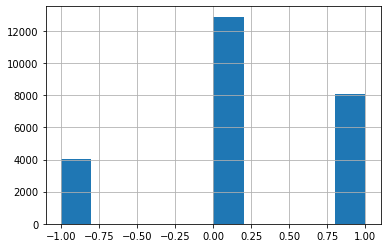

In [87]:
train_df["snorkel"].hist()

In [88]:
# Grid Search
from itertools import product

lrs = [1e-1, 1e-2, 1e-3]
l2s = [0, 1e-1, 1e-2]
n_epochs = [100, 200, 500]
optimizer = ["sgd", "adam"]
thresh = [0.8, 0.9]
lma_best = 0
params_best = []

for params in product(lrs, l2s, n_epochs, optimizer, thresh):
    # do the initial pass to access the accuracies
    label_model.fit(L_train_full, n_epochs=params[2], log_freq=50, seed=123, 
                    optimizer=params[3], lr=params[0], l2=params[1])
    
    # accuracies
    weights = label_model.get_weights()
    
    # LFs above our threshold 
    vals = weights > params[4]
    
    # the LM requires at least 3 LFs to train
    if sum(vals) >= 3:
        L_filtered = L_train_full[:, vals]

        label_model.fit(L_filtered, n_epochs=params[2], log_freq=50, seed=123, 
                        optimizer=params[3], lr=params[0], l2=params[1])

        label_model_acc = label_model.score(L=L_filtered, Y=train_df.sentiment, 
                                        tie_break_policy="abstain")["accuracy"]

        if label_model_acc > lma_best:
            lma_best = label_model_acc
            params_best = params
        
print("best = ", lma_best, " params ", params_best)

best =  0.8399649430324277  params  (0.001, 0.1, 200, 'adam', 0.9)


In [90]:
L_filtered.shape

(25000, 24)

In [96]:
train_df["snorkel"] = label_model.predict(L=L_filtered, 
                               tie_break_policy="abstain")
train_df.describe()

,sentiment,snorkel
count,25000.00000,25000.000000
mean,0.50000,-0.210040
std,0.50001,0.748669
min,0.00000,-1.000000
25%,0.00000,-1.000000
50%,0.50000,0.000000
75%,1.00000,0.000000
max,1.00000,1.000000


In [112]:
from sklearn.model_selection import train_test_split

# Randomly split training into 2k / 23k sets
train_2k, train_23k = train_test_split(train_df, test_size=23000, 
                                      random_state=42, 
                                      stratify=train_df.sentiment)

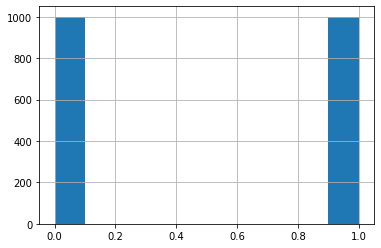

In [103]:
train_2k.sentiment.hist()

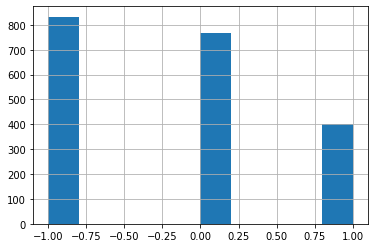

In [104]:
train_2k.snorkel.hist()

In [108]:
train_2k.to_pickle("train_2k.df")

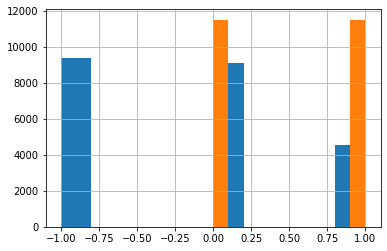

In [105]:
train_23k.snorkel.hist()
train_23k.sentiment.hist()

In [113]:
lbl_train = train_23k[train_23k.snorkel > -1]
print(lbl_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13650 entries, 12023 to 8501
Data columns (total 4 columns):
filename     13650 non-null object
review       13650 non-null object
sentiment    13650 non-null int64
snorkel      13650 non-null int64
dtypes: int64(2), object(2)
memory usage: 533.2+ KB
None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8d45dfd90>,
      dtype=object)

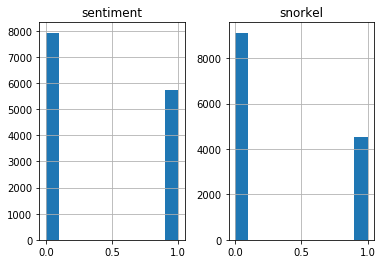

In [114]:
lbl_train.hist()

In [115]:
lbl_train = lbl_train.drop(columns=["sentiment"])
p_sup = lbl_train.rename(columns={"snorkel": "sentiment"})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8d4471450>]],
      dtype=object)

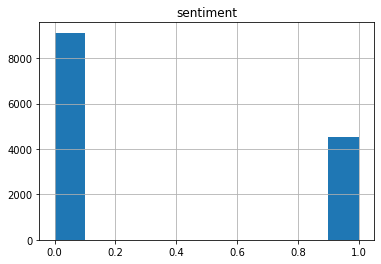

In [116]:
p_sup.hist()

In [117]:
p_sup.to_pickle("snorkel_train_labeled.df")

# Label Unsupervised

In [21]:
# Now apply this to all the unsupervised reviews
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)

# now lets apply on the unsuperisved dataset
L_train_unsup = applier.apply(unsup_df)
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train_unsup[:, vals], n_epochs=params_best[2], 
                optimizer=params_best[3], 
                lr=params_best[0], l2=params_best[1], log_freq=100, seed=42)

unsup_df["snorkel"] = label_model.predict(L=L_train_unsup[:, vals], 
                                          tie_break_policy="abstain")
# rename snorkel to sentiment for concatentation to the training dataset
pred_unsup_lfs = unsup_df[unsup_df.snorkel > -1]
p2 = pred_unsup_lfs.rename(columns={"snorkel": "sentiment"})
print(p2.info())
p2.to_pickle("snorkel-unsup-nbs.df")

/home/ashish/anaconda3/envs/tf21g/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 50000/50000 [01:50<00:00, 451.10it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29583 entries, 1 to 49997
Data columns (total 3 columns):
filename     29583 non-null object
review       29583 non-null object
sentiment    29583 non-null int64
dtypes: int64(1), object(2)
memory usage: 924.5+ KB
None


In [29]:
snorkel_labels = pd.concat((train_df.sentiment, p2.sentiment))

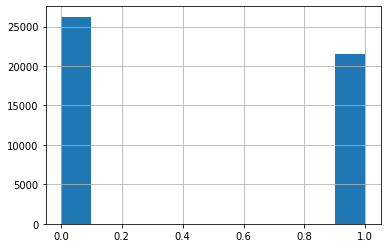

In [30]:
snorkel_labels.hist()

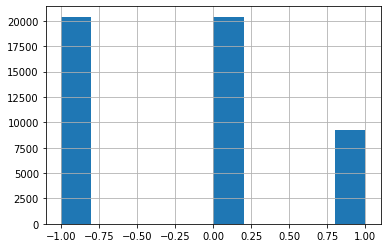

In [56]:
unsup_df.snorkel.hist()

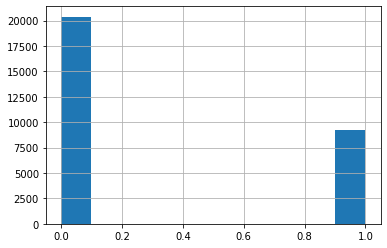

In [22]:
p2.sentiment.hist()

# Increase Positive Label Coverage

In [23]:
'''
     contains(brilliant) = True                1 : 0      =      3.1 : 1.0
     contains(favourite) = True                1 : 0      =      3.0 : 1.0
        contains(highly) = True                1 : 0      =      3.0 : 1.0
    contains(unexpected) = True                1 : 0      =      3.0 : 1.0
         contains(loved) = True                1 : 0      =      3.0 : 1.0
         contains(helps) = True                1 : 0      =      2.9 : 1.0
      contains(provides) = True                1 : 0      =      2.9 : 1.0
        contains(unique) = True                1 : 0      =      2.9 : 1.0
        contains(deeply) = True                1 : 0      =      2.9 : 1.0
        contains(tragic) = True                1 : 0      =      2.9 : 1.0
    *     contains(joan) = True                1 : 0      =      2.8 : 1.0
    contains(incredible) = True                1 : 0      =      2.8 : 1.0
       contains(intense) = True                1 : 0      =      2.8 : 1.0
   contains(fascinating) = True                1 : 0      =      2.8 : 1.0
       contains(unusual) = True                1 : 0      =      2.8 : 1.0
         contains(today) = True                1 : 0      =      2.8 : 1.0
       contains(creates) = True                1 : 0      =      2.8 : 1.0
       contains(awesome) = True                1 : 0      =      2.8 : 1.0
   contains(spectacular) = True                1 : 0      =      2.7 : 1.0
'''

pos_words3 = ["brilliant", "favourite", "highly", "unexpected",
            "loved", "helps", "provides","unique",
            "deeply", "tragic", "incredible", "intense", "fascinating",
            "unusual", "today", "creates", "awesome", "spectacular"]

pos_nb_kw3 = make_keyword_lf(keywords=pos_words3, label=POSITIVE)

# update with more superlatives
@labeling_function()
def superlatives3(x):
    if not isinstance(x.review, str):
        return ABSTAIN
    pos_words = ["brilliant", "favourite", "highly", "unexpected",
            "loved", "helps", "provides","unique",
            "deeply", "tragic", "incredible", "intense", "fascinating",
            "unusual", "today", "creates", "awesome", "spectacular"]
    rv = x.review.lower()
    counts = [rv.count(x) for x in pos_words]
    if sum(counts) >= 2:
        return POSITIVE
    return ABSTAIN

In [24]:
# set of labeling functions
lfs2 = lfs + [pos_nb_kw3, superlatives3]

# Apply the LFs to the unlabeled training data
applier2 = PandasLFApplier(lfs2)

In [25]:
# train on entire training set
L_train_full2 = applier2.apply(train_df)
label_model2 = LabelModel(cardinality=2, verbose=True)
label_model2.fit(L_train_full2, n_epochs=500, optimizer="adam", 
                log_freq=50, seed=42)

/home/ashish/anaconda3/envs/tf21g/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 25000/25000 [01:04<00:00, 384.95it/s]


In [26]:
train_df["snorkel2"] = label_model2.predict(L=L_train_full2, 
                                          tie_break_policy="abstain")

metrics = label_model2.score(L=L_train_full2, Y=train_df.sentiment,
                            tie_break_policy="abstain",
                            metrics=["accuracy", "coverage", "precision",
                                     "recall", "f1"])
label_model_acc = metrics["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")
print("All Metrics: ", metrics)
print(LFAnalysis(L=L_train_full2, lfs=lfs2).lf_summary())

Label Model Accuracy:     79.7%
All Metrics:  {'accuracy': 0.7972824595113918, 'coverage': 0.87432, 'precision': 0.8393418570530287, 'recall': 0.7342990739891813, 'f1': 0.7833145875103917}
                      j Polarity  Coverage  Overlaps  Conflicts
atrocious             0      [0]   0.00816   0.00768    0.00384
terrible              1      [0]   0.05356   0.05356    0.03044
piece_of              2      [0]   0.00084   0.00080    0.00052
woefully_miscast      3      [0]   0.00848   0.00792    0.00580
bad_acting            4      [0]   0.08748   0.08428    0.04868
cheesy_dull           5      [0]   0.05136   0.04980    0.03168
disappoint            6      [0]   0.06812   0.06152    0.04592
crap                  7      [0]   0.04784   0.04396    0.02528
garbage               8      [0]   0.01692   0.01556    0.00856
unsatisfied           9      [0]   0.00388   0.00352    0.00260
ridiculous           10      [0]   0.03976   0.03668    0.02472
bad                  11      [0]   0.03624 

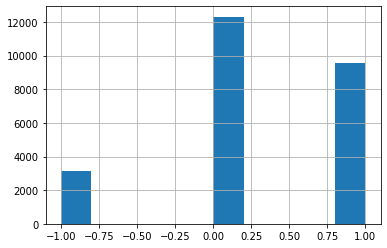

In [27]:
train_df.snorkel2.hist()

In [28]:
# Grid Search
from itertools import product

lrs = [1e-1, 1e-2, 1e-3]
l2s = [0, 1e-1, 1e-2]
n_epochs = [100, 200, 500]
optimizer = ["sgd", "adam"]
thresh = [0.8, 0.9]
lma_best = 0
params_best = []

for params in product(lrs, l2s, n_epochs, optimizer, thresh):
    # do the initial pass to access the accuracies
    label_model2.fit(L_train_full2, n_epochs=params[2], log_freq=50, seed=123, 
                    optimizer=params[3], lr=params[0], l2=params[1])
    
    # accuracies
    weights = label_model2.get_weights()
    
    # LFs above our threshold 
    vals = weights > params[4]
    
    # the LM requires at least 3 LFs to train
    if sum(vals) >= 3:
        L_filtered = L_train_full2[:, vals]

        label_model2.fit(L_filtered, n_epochs=params[2], log_freq=50, seed=123, 
                        optimizer=params[3], lr=params[0], l2=params[1])

        label_model_acc = label_model2.score(L=L_filtered, Y=train_df.sentiment, 
                                        tie_break_policy="abstain")["accuracy"]

        if label_model_acc > lma_best:
            lma_best = label_model_acc
            params_best = params
        
print("best = ", lma_best, " params ", params_best)

best =  0.8393191337670439  params  (0.001, 0, 100, 'sgd', 0.9)


In [29]:
train_df['snorkel3'] = label_model2.predict(L=L_filtered, 
                                          tie_break_policy="abstain")

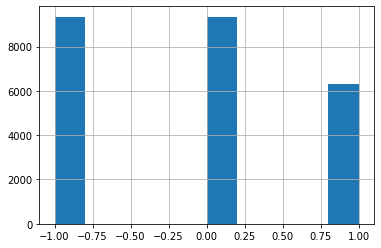

In [30]:
train_df.snorkel3.hist()

In [31]:
# Now apply this to all the unsupervised reviews
# Apply the LFs to the unlabeled training data
applier2 = PandasLFApplier(lfs2)

# now lets apply on the unsuperisved dataset
L_train_unsup2 = applier2.apply(unsup_df)
label_model_unsup = LabelModel(cardinality=2, verbose=True)
label_model_unsup.fit(L_train_unsup2[:, vals], n_epochs=params_best[2], 
                optimizer=params_best[3], 
                lr=params_best[0], l2=params_best[1], log_freq=100, seed=42)

unsup_df["snorkel2"] = label_model_unsup.predict(L=L_train_unsup2[:, vals], 
                                          tie_break_policy="abstain")
# rename snorkel to sentiment for concatentation to the training dataset
pred_unsup_lfs2 = unsup_df[unsup_df.snorkel2 > -1]

/home/ashish/anaconda3/envs/tf21g/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 50000/50000 [02:10<00:00, 384.35it/s]


In [32]:
pred_unsup_lfs2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31238 entries, 1 to 49997
Data columns (total 3 columns):
filename    31238 non-null object
review      31238 non-null object
snorkel2    31238 non-null int64
dtypes: int64(1), object(2)
memory usage: 976.2+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f095415d510>]],
      dtype=object)

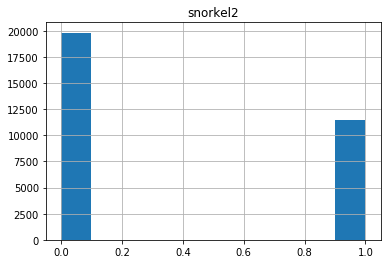

In [33]:
pred_unsup_lfs2.hist()

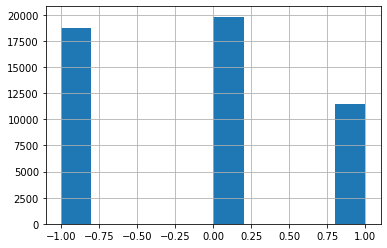

In [34]:
unsup_df.snorkel2.hist()

In [62]:
p3 = pred_unsup_lfs2.rename(columns={"snorkel2": "sentiment"})
print(p3.info())
p3.to_pickle("snorkel-unsup-nbs-v2.df")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31238 entries, 1 to 49997
Data columns (total 4 columns):
filename     31238 non-null object
review       31238 non-null object
snorkel      31238 non-null int64
sentiment    31238 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.2+ MB
None


In [63]:
p3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31238 entries, 1 to 49997
Data columns (total 4 columns):
filename     31238 non-null object
review       31238 non-null object
snorkel      31238 non-null int64
sentiment    31238 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [64]:
pred_unsup_lfs2

,filename,review,snorkel,snorkel2
1,./aclImdb/train/unsup/45898_0.txt,"I'm a fan of B-movies, but this Poverty Row fi...",0,0
3,./aclImdb/train/unsup/19255_0.txt,After his father was killed a young man named ...,0,0
4,./aclImdb/train/unsup/13052_0.txt,"This is kind of an ""Alien""-set-in-a-prison typ...",0,0
9,./aclImdb/train/unsup/46676_0.txt,amateurish space trash.<br /><br />politically...,0,0
11,./aclImdb/train/unsup/555_0.txt,i cant get enough of this movie! i have watche...,1,1
...,...,...,...,...
49991,./aclImdb/train/unsup/33902_0.txt,This film couldn't decide what kind of movie i...,0,0
49994,./aclImdb/train/unsup/30755_0.txt,This is a hugely disappointing sequel and does...,0,0
49995,./aclImdb/train/unsup/21930_0.txt,"This is a fantastic movie, driven primarily by...",1,1
49996,./aclImdb/train/unsup/37482_0.txt,i had a lot of problems with this film but the...,0,0
